# Clone Co-Tracker, Open3D, COLMAP

In [1]:
!git clone https://github.com/facebookresearch/co-tracker
%cd co-tracker
!pip install -e .
!pip install opencv-python matplotlib moviepy flow_vis
!mkdir checkpoints
%cd checkpoints
!wget https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth
%cd ..

fatal: destination path 'co-tracker' already exists and is not an empty directory.
/content/co-tracker
Obtaining file:///content/co-tracker
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cotracker
    Found existing installation: cotracker 3.0
    Uninstalling cotracker-3.0:
      Successfully uninstalled cotracker-3.0
  Running setup.py develop for cotracker
mkdir: cannot create directory ‘checkpoints’: File exists
/content/co-tracker/checkpoints
--2025-12-11 00:53:56--  https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth
Resolving huggingface.co (huggingface.co)... 3.168.203.95, 3.168.203.129, 3.168.203.106, ...
Connecting to huggingface.co (huggingface.co)|3.168.203.95|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cas-bridge.xethub.hf.co/xet-bridge-us/66f28e717967278698d7ebf7/ae694a923aeae71dcdbb5b3ecba33e3c224d2b10b6ffb5dd5ba50c0ab3cdcc45?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Content-Sha256=UNSIGNED-

In [2]:
!sudo apt-get update -y
!sudo apt-get install -y colmap
!pip install -q open3d
!pip install open3d==0.19.0

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

# Imports

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Imports
import os
import torch
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import open3d as o3d
from tqdm import tqdm
import shutil

from cotracker.predictor import CoTrackerPredictor
from base64 import b64encode
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Segment Objects

In [ ]:
video_path = "insert video path"

cap = cv2.VideoCapture(video_path)
ret, background = cap.read()
if not ret:
    raise RuntimeError("Could not read first frame from video")

frames = [background]
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

T = len(frames)
h, w = background.shape[:2]
print(f"Total frames: {T}, size: {w}x{h}")

min_area = 200
TOP_BAND_MAX_Y = 100    # top point of the detected object should be within this threshold
DIST_THRESH = 50.0
MAX_MISSED = 3
masks = []
video_segments = []
detection_frame_idxs = []
tracks = []
next_track_id = 0

def associate_detections_to_tracks(detections, tracks, dist_thresh):
    if len(tracks) == 0 or len(detections) == 0:
        return [], list(range(len(tracks))), list(range(len(detections)))

    track_idxs = [i for i, t in enumerate(tracks) if t["alive"]]
    if len(track_idxs) == 0:
        return [], [], list(range(len(detections)))

    dists = np.full((len(track_idxs), len(detections)), np.inf, dtype=np.float32)

    for ti, t_idx in enumerate(track_idxs):
        t = tracks[t_idx]
        for di, det in enumerate(detections):
            dx = t["cx"] - det["cx"]
            dy = t["cy"] - det["cy"]
            d = np.sqrt(dx * dx + dy * dy)
            dists[ti, di] = d

    matches = []
    matched_tracks = set()
    matched_dets = set()

    while True:
        min_val = dists.min()
        if not np.isfinite(min_val) or min_val > dist_thresh:
            break

        ti, di = np.unravel_index(np.argmin(dists), dists.shape)
        t_idx = track_idxs[ti]
        matches.append((t_idx, di))
        matched_tracks.add(t_idx)
        matched_dets.add(di)
        dists[ti, :] = np.inf
        dists[:, di] = np.inf

    unmatched_tracks = [i for i in range(len(tracks)) if tracks[i]["alive"] and i not in matched_tracks]
    unmatched_dets = [i for i in range(len(detections)) if i not in matched_dets]
    return matches, unmatched_tracks, unmatched_dets


for idx in range(1, T):
    frame = frames[idx]
    diff = cv2.absdiff(frame, background)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Threshold after subtraction
    _, object_mask = cv2.threshold(diff_gray, 30, 255, cv2.THRESH_BINARY)

    # Morphology - To clear small pixel noises that are detected as blobs
    kernel_open = np.ones((3, 3), np.uint8)
    object_mask = cv2.morphologyEx(object_mask, cv2.MORPH_OPEN, kernel_open)
    kernel_close = np.ones((5, 5), np.uint8)
    object_mask = cv2.morphologyEx(object_mask, cv2.MORPH_CLOSE, kernel_close)
    contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detections = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area:
            continue

        x, y, w_box, h_box = cv2.boundingRect(contour)

        # Check if the object is completely insice the frame
        fully_inside = (
            x > 0 and
            y > 0 and
            (x + w_box) < (w - 1) and
            (y + h_box) < (h - 1)
        )
        top_y = np.min(contour[:, 0, 1])

        # Centroid for minimizing repeated detection
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]

        detections.append({
            "contour": contour,
            "cx": cx,
            "cy": cy,
            "fully_inside": fully_inside,
            "top_y": top_y,
            "area": area
        })

    for t in tracks:
        t["updated_this_frame"] = False
    matches, unmatched_tracks, unmatched_dets = associate_detections_to_tracks(detections, tracks, DIST_THRESH)

    # Update matched tracks
    for t_idx, d_idx in matches:
        det = detections[d_idx]
        t = tracks[t_idx]
        t["cx"] = det["cx"]
        t["cy"] = det["cy"]
        t["missed"] = 0
        t["updated_this_frame"] = True

        valid_object_frame = (
            det["fully_inside"] and
            0 <= det["top_y"] <= TOP_BAND_MAX_Y
        )
        if (not t["detected"]) and valid_object_frame:
            t["detected"] = True
            detection_frame_idxs.append(idx)

            mask_clean = np.zeros_like(object_mask, dtype=np.uint8)
            cv2.drawContours(mask_clean, [det["contour"]], -1, 255, thickness=-1)
            masks.append(mask_clean)

            segment_frames = frames[idx:]  # list of frames from current detected frame to end
            video_segments.append(segment_frames)

            print(
                f"Track {t['id']} -> new object #{len(masks)} detected at frame {idx} "
                f"(cx={det['cx']:.1f}, cy={det['cy']:.1f}, top_y={det['top_y']:.1f}, area={det['area']:.1f})"
            )

    for t_idx in unmatched_tracks:
        t = tracks[t_idx]
        t["missed"] += 1
        if t["missed"] > MAX_MISSED:
            t["alive"] = False

    for d_idx in unmatched_dets:
        det = detections[d_idx]
        new_track = {
            "id": next_track_id,
            "cx": det["cx"],
            "cy": det["cy"],
            "missed": 0,
            "alive": True,
            "detected": False,
            "updated_this_frame": True,
        }
        tracks.append(new_track)
        next_track_id += 1

        valid_object_frame = (
            det["fully_inside"] and
            0 <= det["top_y"] <= TOP_BAND_MAX_Y
        )
        if valid_object_frame:
            new_track["detected"] = True
            detection_frame_idxs.append(idx)

            mask_clean = np.zeros_like(object_mask, dtype=np.uint8)
            cv2.drawContours(mask_clean, [det["contour"]], -1, 255, thickness=-1)
            masks.append(mask_clean)

            segment_frames = frames[idx:]
            video_segments.append(segment_frames)

            print(
                f"NEW track {new_track['id']} -> object #{len(masks)} detected at frame {idx} "
                f"(cx={det['cx']:.1f}, cy={det['cy']:.1f}, top_y={det['top_y']:.1f}, area={det['area']:.1f})"
            )

print(f"\nTotal objects detected: {len(masks)}")


Total frames: 72, size: 1280x720
Track 1 -> new object #1 detected at frame 31 (cx=351.1, cy=56.0, top_y=34.0, area=857.0)
Track 0 -> new object #2 detected at frame 36 (cx=529.0, cy=250.9, top_y=39.0, area=90514.0)

Total objects detected: 2


# Run Co-Tracker and Visualize the Tracks

In [7]:
def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")

grid_size = 200 # Change this to increase the number of points
for i in range(len(masks)):
  video_segment = video_segments[i]
  final_mask = masks[i]

  video_np = np.stack(video_segment, axis=0)
  video_np_rgb = video_np[..., ::-1].copy()
  video = torch.from_numpy(video_np_rgb).permute(0, 3, 1, 2).float().unsqueeze(0)

  model = CoTrackerPredictor(checkpoint=os.path.join('./checkpoints/scaled_offline.pth'))
  if torch.cuda.is_available():
    model = model.cuda()
    video = video.cuda()

  start = time.time()
  pred_tracks, pred_visibility = model(video, grid_size=grid_size, segm_mask=torch.from_numpy(final_mask)[None, None])
  end = time.time()
  print("Time for Tracking", end-start)
  vis = Visualizer(save_dir='./videos',pad_value=100,linewidth=2,)
  vis.visualize(video=video, tracks=pred_tracks, visibility=pred_visibility,filename=f'multi_obj{i}');

  torch.cuda.empty_cache()

show_video(f"./videos/multi_obj0.mp4")

Time for Tracking 0.829808235168457


Video saved to ./videos/multi_obj0.mp4
Time for Tracking 9.22383165359497


Video saved to ./videos/multi_obj1.mp4


# Segment the object in each frame for COLMAP

In [8]:
# Clean the Previous Folders
project_dir    = "./colmap_project"
db_path        = os.path.join(project_dir, "database.db")
sparse_dir     = os.path.join(project_dir, "sparse")
text_model_dir = os.path.join(project_dir, "sparse_text")
images_dir     = "./frames_colmap"
frames_dir = "./frames_colmap"
masks_dir  = "./masks_colmap"

# Celar the old files
print("\nRemoving previous colmap_project/")
shutil.rmtree(project_dir, ignore_errors=True)
print("Removing previous frames_colmap/")
shutil.rmtree(frames_dir, ignore_errors=True)
print("Removing previous masks_colmap/")
shutil.rmtree(masks_dir, ignore_errors=True)


Removing previous colmap_project/
Removing previous frames_colmap/
Removing previous masks_colmap/


In [9]:
# Run Co-Tracker and use the points to segment the object
frames_root = "./frames_colmap"
masks_root  = "./masks_colmap"
os.makedirs(frames_root, exist_ok=True)
os.makedirs(masks_root, exist_ok=True)

# Create a single CoTracker model and reuse it across segments
model = CoTrackerPredictor(checkpoint="./checkpoints/scaled_offline.pth").to(device)
model.eval()

for i in range(len(masks)):
    print(f"\nProcessing SEGMENT {i}")

    video_segment = video_segments[i]
    init_mask     = masks[i].astype(np.uint8)

    # Create per-segment folders
    seg_frames_dir = os.path.join(frames_root, f"segment_{i:02d}")
    seg_masks_dir  = os.path.join(masks_root,  f"segment_{i:02d}")
    os.makedirs(seg_frames_dir, exist_ok=True)
    os.makedirs(seg_masks_dir, exist_ok=True)

    seg_np = np.stack(video_segment, axis=0)
    T_seg, H, W, _ = seg_np.shape

    seg_rgb = seg_np[..., ::-1].copy() # BGR->RGB
    video_t = torch.from_numpy(seg_rgb).permute(0, 3, 1, 2).float().unsqueeze(0).to(device)
    segm_mask_t = torch.from_numpy(init_mask)[None, None].to(device)

    # Run CoTracker on this segment
    with torch.no_grad():
        pred_tracks, pred_visibility = model(
            video_t,
            grid_size=grid_size,
            segm_mask=segm_mask_t
        )

    tracks_np = pred_tracks[0].detach().cpu().numpy()
    vis_np    = pred_visibility[0].detach().cpu().numpy()
    T_seg, N = tracks_np.shape[0], tracks_np.shape[1]

    print(f"CoTracker: T_seg={T_seg}, N={N}")

    # Save each frame/mask inside this segment's folder
    for t in range(T_seg):
        frame_bgr = seg_np[t]

        if t == 0:
            # first frame uses your initial mask
            mask = (init_mask > 0).astype(np.uint8) * 255
        else:
            # build mask from CoTracker points
            mask = np.zeros((H, W), dtype=np.uint8)

            vis_t = vis_np[t] > 0.5
            xs = tracks_np[t, vis_t, 0]
            ys = tracks_np[t, vis_t, 1]

            for u, v in zip(xs, ys):
                u_i, v_i = int(round(u)), int(round(v))
                if 0 <= u_i < W and 0 <= v_i < H:
                    mask[v_i, u_i] = 255

            # dilate to cover the object with extra region for better results in COLMAP
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
            mask = cv2.dilate(mask, kernel, iterations=1)

        masked_frame = frame_bgr.copy()
        masked_frame[mask == 0] = 0
        frame_name = os.path.join(seg_frames_dir, f"frame_{t:04d}.png")
        mask_name  = os.path.join(seg_masks_dir,  f"mask_{t:04d}.png")

        cv2.imwrite(frame_name, masked_frame)
        cv2.imwrite(mask_name, mask)

    print(f"SEGMENT {i} -> Saved {T_seg} frames into {seg_frames_dir}")

print("\nAll segments processed.")



Processing SEGMENT 0
CoTracker: T_seg=41, N=43
SEGMENT 0 -> Saved 41 frames into ./frames_colmap/segment_00

Processing SEGMENT 1
CoTracker: T_seg=36, N=4221
SEGMENT 1 -> Saved 36 frames into ./frames_colmap/segment_01

All segments processed.


# Run COLMAP for Extrinsics

In [10]:
# Run COLMAP to save the extrinsics
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["COLMAP_QT_OFFSCREEN"] = "1"
print("QT_QPA_PLATFORM:", os.environ["QT_QPA_PLATFORM"])

frames_root = "./frames_colmap"
colmap_root = "./colmap_project"
os.makedirs(colmap_root, exist_ok=True)

num_segments = len(masks)
for i in range(num_segments):
    seg_frames_dir = os.path.join(frames_root, f"segment_{i:02d}")
    if not os.path.isdir(seg_frames_dir):
        print(f"\nNo frames directory at {seg_frames_dir}, skipping.")
        continue

    print(f"\nRunning COLMAP on {seg_frames_dir}")

    proj_dir    = os.path.join(colmap_root, f"segment_{i:02d}")
    db_path     = os.path.join(proj_dir, "database.db")
    sparse_dir  = os.path.join(proj_dir, "sparse")
    text_dir    = os.path.join(proj_dir, "sparse_text")

    # Clean old run
    shutil.rmtree(proj_dir, ignore_errors=True)
    os.makedirs(proj_dir, exist_ok=True)
    os.makedirs(sparse_dir, exist_ok=True)
    os.makedirs(text_dir, exist_ok=True)

    # Feature Extraction
    print("Feature extraction")
    !QT_QPA_PLATFORM=offscreen colmap feature_extractor \
        --database_path {db_path} \
        --image_path {seg_frames_dir} \
        --ImageReader.single_camera 1 \
        --SiftExtraction.use_gpu 0 \
        --SiftExtraction.max_num_features 8192

    # Feature atching (CPU only)
    print("Exhaustive matching")
    !QT_QPA_PLATFORM=offscreen colmap exhaustive_matcher \
        --database_path {db_path} \
        --SiftMatching.use_gpu 0

    # Mapper
    print("Mapper")
    !QT_QPA_PLATFORM=offscreen colmap mapper \
        --database_path {db_path} \
        --image_path {seg_frames_dir} \
        --output_path {sparse_dir} \
        --Mapper.num_threads 4

    # Convert to TXT if model exists
    if os.path.exists(os.path.join(sparse_dir, "0")):
        print("Model converter -> TXT")
        !QT_QPA_PLATFORM=offscreen colmap model_converter \
            --input_path {sparse_dir}/0 \
            --output_path {text_dir} \
            --output_type TXT
        print(f"Done. Text model at {text_dir}")
    else:
        print(f"ERROR: No sparse model created, reconstruction failed.")


QT_QPA_PLATFORM: offscreen

Running COLMAP on ./frames_colmap/segment_00
Feature extraction

Feature extraction

Processed file [1/41]
  Name:            frame_0002.png
  Dimensions:      1280 x 720
  Camera:          #1 - SIMPLE_RADIAL
  Focal Length:    1536.00px
  Features:        29
Processed file [2/41]
  Name:            frame_0006.png
  Dimensions:      1280 x 720
  Camera:          #1 - SIMPLE_RADIAL
  Focal Length:    1536.00px
  Features:        23
Processed file [3/41]
  Name:            frame_0001.png
  Dimensions:      1280 x 720
  Camera:          #1 - SIMPLE_RADIAL
  Focal Length:    1536.00px
  Features:        28
Processed file [4/41]
  Name:            frame_0000.png
  Dimensions:      1280 x 720
  Camera:          #1 - SIMPLE_RADIAL
  Focal Length:    1536.00px
  Features:        7
Processed file [5/41]
  Name:            frame_0005.png
  Dimensions:      1280 x 720
  Camera:          #1 - SIMPLE_RADIAL
  Focal Length:    1536.00px
  Features:        22
Processed fil

# Triangulate the Co-Tracker Points

In [11]:
def save_pcd(points_xyz: np.ndarray, filename: str):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    if points_xyz.size == 0:
        print(f"[WARN] No points to save for {filename}")
        return
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(points_xyz.astype(np.float32))
    o3d.io.write_point_cloud(filename, pc)
    print(f"[INFO] Saved PCD:", filename)

def read_cameras_txt(path):
    cameras = {}
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or len(line) == 0:
                continue
            elems = line.split()
            camera_id = int(elems[0])
            model = elems[1]
            width = int(elems[2])
            height = int(elems[3])
            params = list(map(float, elems[4:]))
            cameras[camera_id] = (model, width, height, params)
    return cameras

def qvec2rotmat(qvec):
    qw, qx, qy, qz = qvec
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2,     2*qx*qy - 2*qz*qw,         2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw,         1 - 2*qx**2 - 2*qz**2,     2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw,         2*qy*qz + 2*qx*qw,         1 - 2*qx**2 - 2*qy**2]
    ], dtype=np.float64)
    return R

def read_images_txt(path):
    images = {}
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or len(line) == 0:
                continue
            elems = line.split()
            # line can be metadata or 2D-3D correspondences
            try:
                image_id = int(elems[0])
            except ValueError:
                continue
            if len(elems) < 10:
                continue
            qvec      = np.array(list(map(float, elems[1:5])))
            tvec      = np.array(list(map(float, elems[5:8])))
            camera_id = int(elems[8])
            image_name = elems[9]
            images[image_name] = {
                "id": image_id,
                "qvec": qvec,
                "tvec": tvec,
                "camera_id": camera_id,
            }
    return images

def triangulate_point_multi_view(P_list, x_list):
    A = []
    for P, (u, v) in zip(P_list, x_list):
        p1 = P[0]; p2 = P[1]; p3 = P[2]
        A.append(u * p3 - p1)
        A.append(v * p3 - p2)
    A = np.stack(A, axis=0)
    _, _, Vt = np.linalg.svd(A)
    X_h = Vt[-1]
    X_h /= X_h[3]
    return X_h[:3]

frames_root = "./frames_colmap"
colmap_root = "./colmap_project"
num_segments = len(masks)

for i in range(num_segments):
    print(f"\n[SEG {i}] Triangulation")

    seg_frames_dir = os.path.join(frames_root, f"segment_{i:02d}")
    proj_dir       = os.path.join(colmap_root, f"segment_{i:02d}")
    text_dir       = os.path.join(proj_dir, "sparse_text")

    if not (os.path.isdir(seg_frames_dir) and os.path.isdir(text_dir)):
        print(f"[SEG {i}] Missing frames or COLMAP model, skipping.")
        continue

    cams_path   = os.path.join(text_dir, "cameras.txt")
    images_path = os.path.join(text_dir, "images.txt")
    if not (os.path.exists(cams_path) and os.path.exists(images_path)):
        print(f"[SEG {i}] cameras.txt or images.txt missing, skipping.")
        continue

    cameras = read_cameras_txt(cams_path)
    images  = read_images_txt(images_path)

    if len(cameras) == 0 or len(images) == 0:
        print(f"[SEG {i}] No cameras or images parsed, skipping.")
        continue

    camera_id = list(cameras.keys())[0]
    model_cam, width, height, params = cameras[camera_id]

    if model_cam == "PINHOLE":
        fx, fy, cx, cy = params
    elif model_cam in ("SIMPLE_PINHOLE", "SIMPLE_RADIAL", "RADIAL"):
        f, cx, cy = params[0], params[1], params[2]
        fx = fy = f
    else:
        print(f"[SEG {i}] Unsupported camera model {model_cam}, skipping.")
        continue

    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]], dtype=np.float64)

    frame_files = sorted(
        [f for f in os.listdir(seg_frames_dir) if f.startswith("frame_") and f.endswith(".png")]
    )
    T_seg = len(frame_files)
    print(f"[SEG {i}] T_seg={T_seg}, #COLMAP images={len(images)}")

    Rs = []
    ts = []
    valid_frame = []
    for t in range(T_seg):
        img_name = f"frame_{t:04d}.png"
        if img_name not in images:
            Rs.append(None)
            ts.append(None)
            valid_frame.append(False)
        else:
            info = images[img_name]
            R = qvec2rotmat(info["qvec"])
            tvec = info["tvec"]
            Rs.append(R)
            ts.append(tvec)
            valid_frame.append(True)

    Rs = np.array(Rs, dtype=object)
    ts = np.array(ts, dtype=object)
    valid_frame = np.array(valid_frame, dtype=bool)
    print(f"[SEG {i}] Frames with valid pose: {valid_frame.sum()}/{T_seg}")

    # run co-tracker again (since we did not save the tracks before)
    video_segment = video_segments[i]
    init_mask     = masks[i].astype(np.uint8)

    seg_np  = np.stack(video_segment, axis=0)  # (T_seg, H, W, 3)
    seg_rgb = seg_np[..., ::-1].copy()
    video_t = torch.from_numpy(seg_rgb).permute(0, 3, 1, 2).float().unsqueeze(0).to(device)

    segm_mask_t = torch.from_numpy(init_mask)[None, None].to(device)

    with torch.no_grad():
        pred_tracks, pred_visibility = model(
            video_t,
            grid_size=grid_size,
            segm_mask=segm_mask_t
        )

    tracks_np = pred_tracks[0].detach().cpu().numpy()      # (T_seg, N, 2)
    vis_np    = pred_visibility[0].detach().cpu().numpy()  # (T_seg, N)
    T_seg_check, N = tracks_np.shape[0], tracks_np.shape[1]
    print(f"[SEG {i}] CoTracker: T_seg={T_seg_check}, N={N}")

    if T_seg_check != T_seg:
        print(f"[SEG {i}] WARNING: T_seg mismatch between frames and video_segments!")

    # --- Triangulate each track ---
    points_3d = []

    for n in range(N):
        P_list = []
        x_list = []

        for t in range(T_seg):
            if t >= len(valid_frame):
                continue
            if not valid_frame[t]:
                continue
            if vis_np[t, n] <= 0.5:
                continue
            if Rs[t] is None or ts[t] is None:
                continue

            R_t = Rs[t]
            t_t = ts[t]

            P_t = K @ np.hstack([R_t, t_t.reshape(3, 1)])  # (3,4)
            u, v = tracks_np[t, n]
            P_list.append(P_t)
            x_list.append((u, v))

        if len(P_list) >= 2:
            X = triangulate_point_multi_view(P_list, x_list)
            points_3d.append(X)

    points_3d = np.array(points_3d, dtype=np.float32)
    print(f"[SEG {i}] Triangulated points: {points_3d.shape}")

    # Save per-segment PCD
    out_pcd = os.path.join(proj_dir, "cotracker_dense_cloud.pcd")
    save_pcd(points_3d, out_pcd)



[SEG 0] Triangulation
[SEG 0] cameras.txt or images.txt missing, skipping.

[SEG 1] Triangulation
[SEG 1] T_seg=36, #COLMAP images=12
[SEG 1] Frames with valid pose: 12/36
[SEG 1] CoTracker: T_seg=36, N=4221
[SEG 1] Triangulated points: (4220, 3)
[INFO] Saved PCD: ./colmap_project/segment_01/cotracker_dense_cloud.pcd


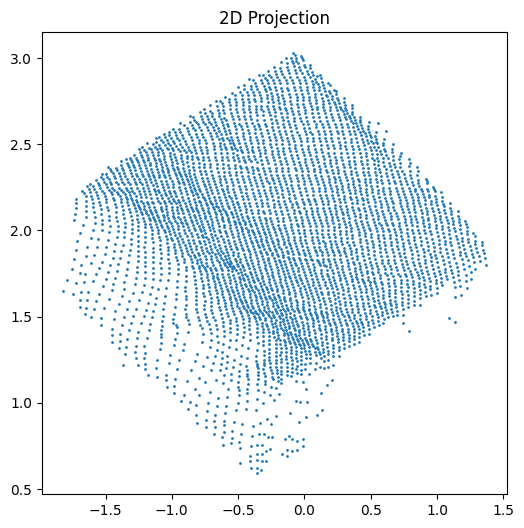

In [ ]:
import open3d as o3d
pcd_path = "insert .pcd file here"
pcd = o3d.io.read_point_cloud(pcd_path)
import numpy as np
import matplotlib.pyplot as plt

points = np.asarray(pcd.points)

plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s=1)
plt.title("2D Projection")
plt.show()
